<a href="https://colab.research.google.com/github/lsteffenel/CHPS0905/blob/main/Encoder_Decoder_Covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Des modèles avancés pour problèmes récents

Dans cet exercice, allons utiliser le modèle encodeur-décodeur pour prédire le nombre de cas de victimes du COVID-19.

Tout d'abord, téléchargéons les données :

In [1]:
!wget https://raw.githubusercontent.com/lsteffenel/CHPS0905/refs/heads/main/datasets/COVID_19_until_2021_02_01.csv
!wget https://raw.githubusercontent.com/lsteffenel/CHPS0905/refs/heads/main/datasets/COVID_19_complete.csv

--2024-11-23 11:52:50--  https://raw.githubusercontent.com/lsteffenel/CHPS0905/refs/heads/main/datasets/COVID_19_until_2021_02_01.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3828956 (3.7M) [text/plain]
Saving to: ‘COVID_19_until_2021_02_01.csv’

COVID_19_until_2021 100%[===================>]   3.65M  --.-KB/s    in 0.04s   

2024-11-23 11:52:51 (81.8 MB/s) - ‘COVID_19_until_2021_02_01.csv’ saved [3828956/3828956]

--2024-11-23 11:52:51--  https://raw.githubusercontent.com/lsteffenel/CHPS0905/refs/heads/main/datasets/COVID_19_complete.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

In [2]:
from datetime import datetime

import pandas as pd


def get_df_until_2021_02_01():
    df = pd.read_csv(
        'COVID_19_until_2021_02_01.csv',
        date_parser = lambda d: datetime.strptime(d, '%Y-%m-%d'),
        index_col = 'Date'
    )
    return df


def get_df_complete():
    df = pd.read_csv(
        'COVID_19_complete.csv',
        date_parser = lambda d: datetime.strptime(d, '%Y-%m-%d'),
        index_col = 'Date'
    )
    return df

def sliding_window(ts, features, target_len = 1):
    X, Y = [], []
    for i in range(features + target_len, len(ts) + 1):
        X.append(ts[i - (features + target_len):i - target_len])
        Y.append(ts[i - target_len:i])
    return X, Y


def get_date_index(ts, date_index):
    count = 0
    for i, r in ts.iteritems():
        if date_index == datetime.strftime(i, '%Y-%m-%d'):
            return count
        count = count + 1
    return -1


def get_train_test_datasets(ts, w, target_len, train_dates, test_dates):
    X, Y = sliding_window(ts, w, target_len)
    train_from = get_date_index(ts, train_dates[0]) - w
    train_to = get_date_index(ts, train_dates[1]) - w
    test_from = get_date_index(ts, test_dates[0]) - w
    test_to = get_date_index(ts, test_dates[1]) - w

    x_train = torch.tensor(data = X[train_from:train_to]).float()
    y_train = torch.tensor(data = Y[train_from:train_to]).float()

    x_test = torch.tensor(data = X[test_from:test_to]).float()
    y_test = torch.tensor(data = Y[test_from:test_to]).float()

    return x_train, x_test, y_train, y_test


## Encodeur-Décodeur

Un modèle encodeur-décodeur ressemble à un sablier : la partie encodeur fait une séquence de convolutions pour extraire les informations des données, un peu comme dans une architecture de classification classique. L'information resumé se retrouve dans ce qu'on appelle "espace latent".

La partie décodeur utilise de **fonctions opposées** pour reconstruire une donnée à partir du "résumé" de l'encodeur.

On peut essayer de reconstruire les données de l'entrée, mais aussi de cibler une donnée de sortie différente : dans ce cas, on projète la représentation de l'espace latent vers quelque chose d'autre.

Le prochain paragraphe définit des fonctions pour l'encodeur, le décodeur (essayez de voir que l'ordre d'appel des couches est inversé), ainsi que d'autres fonctions auxiliaires nécessaires à un modèle Pytorch (initialisation, train, predict).

In [3]:
import copy

import numpy as np
import random
import torch
import torch.nn as nn
from torch import optim


class Encoder(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers = 1):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)

    def forward(self, x):
        flat = x.view(x.shape[0], x.shape[1], self.input_size)
        out, h = self.gru(flat)
        return out, h


class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, hidden_dl_size, output_size = 1, num_layers = 1):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers)
        self.lin1 = nn.Linear(hidden_size, hidden_dl_size)
        self.lin2 = nn.Linear(hidden_dl_size, output_size)

    def forward(self, x, h):
        out, h = self.gru(x.unsqueeze(0), h)
        y = torch.relu(self.lin1(out.squeeze(0)))
        y = self.lin2(y)
        return y, h


class EncoderDecoder(nn.Module):

    def __init__(self, hidden_size, hidden_dl_size, input_size = 1, output_size = 1):
        super(EncoderDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.encoder = Encoder(input_size = input_size, hidden_size = hidden_size)
        self.decoder = Decoder(input_size = output_size, hidden_size = hidden_size,
                               hidden_dl_size = hidden_dl_size, output_size = output_size)

    def train_model(
            self, train, target, val, val_target,
            epochs, target_len, method = 'recursive',
            tfr = 0.5, lr = 0.01, dynamic_tf = False
    ):
        losses = np.full(epochs, np.nan)
        optimizer = optim.Adam(self.parameters(), lr = lr)
        criterion = nn.MSELoss()

        best_val_loss = 1000_000
        best_model_params = None

        for e in range(epochs):
            predicted = torch.zeros(target_len, train.shape[1], 1)
            optimizer.zero_grad()
            _, enc_h = self.encoder(train)

            dec_in = train[-1, :, 0].unsqueeze(1)
            dec_h = enc_h

            if method == 'recursive':
                for t in range(target_len):
                    dec_out, dec_h = self.decoder(dec_in, dec_h)
                    predicted[t] = dec_out
                    dec_in = dec_out

            if method == 'teacher_forcing':
                # use teacher forcing
                if random.random() < tfr:
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = target[t, :].unsqueeze(1)
                # predict recursively
                else:
                    for t in range(target_len):
                        dec_out, dec_h = self.decoder(dec_in, dec_h)
                        predicted[t] = dec_out
                        dec_in = dec_out

            if method == 'mixed_teacher_forcing':
                # predict using mixed teacher forcing
                for t in range(target_len):
                    dec_out, dec_h = self.decoder(dec_in, dec_h)
                    predicted[t] = dec_out
                    # predict with teacher forcing
                    if random.random() < tfr:
                        dec_in = target[t, :].unsqueeze(1)
                    # predict recursively
                    else:
                        dec_in = dec_out

            loss = criterion(predicted.squeeze(2), target)
            loss.backward()
            optimizer.step()

            val_predicted = self.predict(val, val_target.size(0))
            val_loss = criterion(val_predicted.squeeze(2), val_target)

            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model_params = copy.deepcopy(self.state_dict())

            losses[e] = loss.item()

            if e % 10 == 0:
                print(f'Epoch {e}/{epochs}| '
                      f'test: {round(loss.item(), 4)}, '
                      f'val: {round(val_loss.item(), 4)}')

            # dynamic teacher forcing
            if dynamic_tf and tfr > 0:
                tfr = tfr - 0.02

        return best_model_params, best_val_loss

    def predict(self, x, target_len):
        y = torch.zeros(target_len, x.shape[1], 1)

        _, enc_h = self.encoder(x)
        dec_in = x[-1, :, 0].unsqueeze(1)
        dec_h = enc_h

        for t in range(target_len):
            dec_out, dec_h = self.decoder(dec_in, dec_h)
            y[t] = dec_out
            dec_in = dec_out

        return y


On fera un premier modèle avec une partie des données (janvier 2020 à janvier 2021), et quelques pays seulement.

In [4]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

df = get_df_until_2021_02_01()
start_date = '2020-01-01'
end_date = '2021-02-01'
countries = ['Italy', 'Russia', 'Hungary', 'Austria', 'Israel', 'Poland']

# size of the sliding window
w = 120
# length of prediction
out = 60
# number of training epochs
epochs = 200

# Initializing the model
params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1,
    'lr':             .01,
    'tfr':            .1
}

# Hyper-parameters:
hidden_size = params['hidden_size']
hidden_dl_size = params['hidden_dl_size']
lr = params['lr']
tfr = params['tfr']



<ipython-input-2-4cfee79f0621>:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


#formater les données

avant de lancer l'entraînement, il faut également formater les données en tant que "séries temporelles", i.e., créer des fenêtres de données (X jours de mesures pour Y jours de cible). On fait également le nettoyage des données, s'il y a des valeurs manquantes.

In [5]:
import statsmodels.api as sm

# Preparing Sliding-window Datasets
X, Y = [], []
for c in countries:
    # diff
    ts_df = df[df['Country'] == c]['Confirmed'].diff().dropna()
    train = ts_df[start_date:end_date].values
    # Normalized time series
    train = train / max(train)
    # Statistical pre-processing
    _, train_hp_trend = sm.tsa.filters.hpfilter(train)
    train_cf_cycle, _ = sm.tsa.filters.cffilter(train)

    D = []
    for i in range(len(train)):
        D.append([train[i], train_hp_trend[i], train_cf_cycle[i]])

    # input - output for country
    X_c, Y_c = sliding_window(D, w, out)
    X.extend(X_c)
    Y.extend(Y_c)

# Train-Validation Split
X_train, Y_train = [], []
X_val, Y_val = [], []
for i in range(len(X)):
    if random.random() > .8:
        X_val.append(X[i])
        Y_val.append(Y[i])
    else:
        X_train.append(X[i])
        Y_train.append(Y[i])

# Converting datasets to tensors
x_train = torch.tensor(X_train).float().transpose(0, 1)
y_train = torch.tensor(Y_train).float().transpose(0, 1)[:, :, 0]
x_val = torch.tensor(X_val).float().transpose(0, 1)
y_val = torch.tensor(Y_val).float().transpose(0, 1)[:, :, 0]



Enfin, l'entraînement 💪

Ici on afiche les résultats à chaque 10 époques d'entraînement (c'est assez rapide, avec un GPU)

In [6]:
model_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model = EncoderDecoder(**model_params)
model.train()

# Training and getting the results
model_params, val = model.train_model(
        x_train, y_train, x_val, y_val, epochs, out,
        method = 'mixed_teacher_forcing', tfr = tfr, lr = lr)

Epoch 0/200| test: 0.3876, val: 0.3004
Epoch 10/200| test: 0.0829, val: 0.0681
Epoch 20/200| test: 0.0732, val: 0.0661
Epoch 30/200| test: 0.065, val: 0.0589
Epoch 40/200| test: 0.0509, val: 0.0469
Epoch 50/200| test: 0.0441, val: 0.0401
Epoch 60/200| test: 0.0377, val: 0.0352
Epoch 70/200| test: 0.0316, val: 0.0337
Epoch 80/200| test: 0.0461, val: 0.0407
Epoch 90/200| test: 0.0403, val: 0.043
Epoch 100/200| test: 0.0384, val: 0.0354
Epoch 110/200| test: 0.0359, val: 0.0342
Epoch 120/200| test: 0.0327, val: 0.0333
Epoch 130/200| test: 0.0314, val: 0.0333
Epoch 140/200| test: 0.0281, val: 0.032
Epoch 150/200| test: 0.0282, val: 0.0321
Epoch 160/200| test: 0.0349, val: 0.0738
Epoch 170/200| test: 0.0387, val: 0.0376
Epoch 180/200| test: 0.0347, val: 0.0343
Epoch 190/200| test: 0.0272, val: 0.0319


Et pour tester le modèle, on essaye de prédire la tendance en Autriche entre février et avril 2021 (regardez la date de fin)

<ipython-input-2-4cfee79f0621>:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


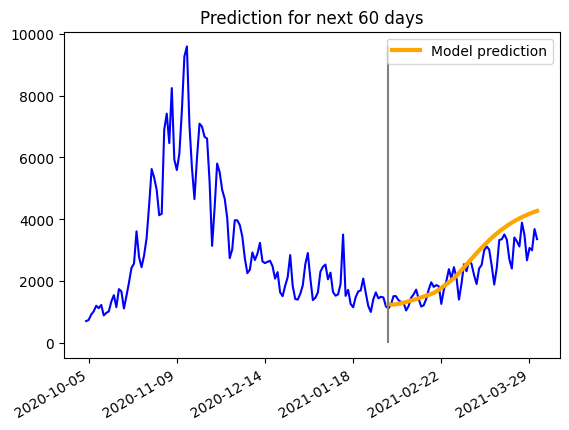

In [7]:
from datetime import datetime
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model.eval()
from_date = '2020-10-04'
to_date = '2021-04-01'
date_fmt = '%Y-%m-%d'
country = 'Austria'
df = get_df_complete()
au_ts_df = df[df['Country'] == country]['Confirmed'].diff().dropna()
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

x = torch.tensor([X]).float().transpose(0, 1)
model.eval()
predicted = model.predict(x, 60)

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.strptime(from_date, date_fmt)
end_date = start_date + dt.timedelta(days = len(in_seq))
prediction_date = start_date + dt.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))

plt.title(f'Prediction for next 60 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'Model prediction',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


# La même chose, mais avec un modèle TCN

Nous allons reprendre le même dataset, mais avec un modèle TCN cette fois-ci.

In [8]:
import torch
from typing import OrderedDict

import torch.nn as nn
from torch.nn.utils import weight_norm


class Crop(nn.Module):

    def __init__(self, crop_size):
        super(Crop, self).__init__()
        self.crop_size = crop_size

    def forward(self, x):
        return x[:, :, :-self.crop_size].contiguous()


class TemporalCasualLayer(nn.Module):

    def __init__(self,
                 n_inputs,
                 n_outputs,
                 kernel_size,
                 stride,
                 dilation,
                 dropout = 0.2,
                 act = 'relu',
                 slices = 2,
                 use_bias = True
                 ):
        super(TemporalCasualLayer, self).__init__()
        padding = (kernel_size - 1) * dilation
        conv_params = {
            'kernel_size': kernel_size,
            'stride':      stride,
            'padding':     padding,
            'dilation':    dilation
        }
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh()
        }

        self.use_bias = use_bias

        layers = OrderedDict()
        for s in range(1, slices + 1):
            if s == 1:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_inputs, n_outputs, **conv_params))
            else:
                layers[f'conv{s}'] = weight_norm(nn.Conv1d(n_outputs, n_outputs, **conv_params))
            layers[f'crop{s}'] = Crop(padding)
            layers[f'act{s}'] = activations[act]
            layers[f'dropout{s}'] = nn.Dropout(dropout)

        self.net = nn.Sequential(layers)

        if n_inputs != n_outputs and use_bias:
            self.bias = nn.Conv1d(n_inputs, n_outputs, 1)
        else:
            self.bias = None

        self.relu = nn.ReLU()

    def forward(self, x):
        y = self.net(x)
        if self.use_bias:
            b = x if self.bias is None else self.bias(x)
            return self.relu(y + b)
        else:
            return self.relu(y)


class TemporalConvolutionNetwork(nn.Module):

    def __init__(self,
                 num_inputs,
                 num_channels,
                 kernel_size = 2,
                 dropout = 0.2,
                 slices = 2,
                 act = 'relu',
                 use_bias = True
                 ):
        super(TemporalConvolutionNetwork, self).__init__()
        layers = []
        num_levels = len(num_channels)

        tcl_param = {
            'kernel_size': kernel_size,
            'stride':      1,
            'dropout':     dropout,
            'slices':      slices,
            'act':         act,
            'use_bias':    use_bias
        }

        for i in range(num_levels):
            dilation = 2**i
            in_ch = num_inputs if i == 0 else num_channels[i - 1]
            out_ch = num_channels[i]
            tcl_param['dilation'] = dilation
            tcl = TemporalCasualLayer(in_ch, out_ch, **tcl_param)
            layers.append(tcl)

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class TcnClassifier(nn.Module):

    def __init__(self, **params):
        super(TcnClassifier, self).__init__()
        self.num_channels = params['num_channels']
        self.num_classes = params.pop('num_classes')

        self.tcn = TemporalConvolutionNetwork(**params)
        self.linear = nn.Linear(self.num_channels[-1], self.num_classes)

    def forward(self, x):
        x = self.tcn(x)
        x = self.linear(x[:, :, -1])
        y = torch.log_softmax(x, dim = 1)
        return y


In [9]:
model2_params = {
    'hidden_size':    32,
    'hidden_dl_size': 12,
    'input_size':     3,
    'output_size':    1
}

model2 = EncoderDecoder(**model2_params)
model2.train()

# Training and getting the results
model2_params, val2 = model2.train_model(
        x_train, y_train, x_val, y_val, epochs, out,
       tfr = tfr, lr = lr)

Epoch 0/200| test: 0.1275, val: 0.0974
Epoch 10/200| test: 0.0722, val: 0.0651
Epoch 20/200| test: 0.0578, val: 0.0513
Epoch 30/200| test: 0.0462, val: 0.0389
Epoch 40/200| test: 0.0368, val: 0.04
Epoch 50/200| test: 0.0412, val: 0.0349
Epoch 60/200| test: 0.0348, val: 0.0328
Epoch 70/200| test: 0.0318, val: 0.0303
Epoch 80/200| test: 0.0338, val: 0.032
Epoch 90/200| test: 0.0293, val: 0.0294
Epoch 100/200| test: 0.0289, val: 0.0545
Epoch 110/200| test: 0.0375, val: 0.034
Epoch 120/200| test: 0.0273, val: 0.0271
Epoch 130/200| test: 0.0229, val: 0.0213
Epoch 140/200| test: 0.0208, val: 0.019
Epoch 150/200| test: 0.0196, val: 0.0181
Epoch 160/200| test: 0.0186, val: 0.0172
Epoch 170/200| test: 0.0176, val: 0.0163
Epoch 180/200| test: 0.0168, val: 0.0152
Epoch 190/200| test: 0.016, val: 0.0145


L'évaluation est presque identique, juste on utilise "model2" à la place de "model" afin de garder les deux variantes en mémoire.

<ipython-input-2-4cfee79f0621>:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


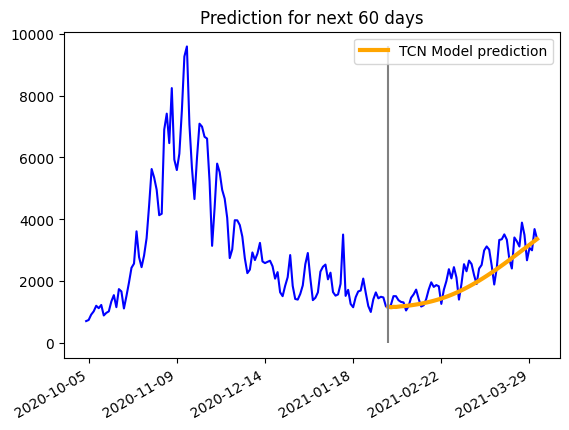

In [10]:
from datetime import datetime
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

model2.eval()
from_date = '2020-10-04'
to_date = '2021-04-01'
date_fmt = '%Y-%m-%d'
country = 'Austria'
df = get_df_complete()
au_ts_df = df[df['Country'] == country]['Confirmed'].diff().dropna()
ts = au_ts_df[from_date:to_date].values
test = ts[:120]
max_test = max(test)
test = test / max_test
test_hp_cycle, test_hp_trend = sm.tsa.filters.hpfilter(test)
test_cf_cycle, test_cf_trend = sm.tsa.filters.cffilter(test)
X = []
for i in range(len(test)):
    X.append([test[i], test_hp_trend[i], test_cf_cycle[i]])

x = torch.tensor([X]).float().transpose(0, 1)
model2.eval()
predicted = model2.predict(x, 60)

in_seq = [e * max_test for e in x[:, -1, 0].view(-1).tolist()]
target_seq = list(ts[120:])
pred_seq = [e * max_test for e in predicted[:, -1, 0].view(-1).tolist()]
x_axis = range(len(in_seq) + len(pred_seq))
start_date = datetime.strptime(from_date, date_fmt)
end_date = start_date + dt.timedelta(days = len(in_seq))
prediction_date = start_date + dt.timedelta(days = len(in_seq) + len(pred_seq))
date_list = mdates.drange(start_date, prediction_date, dt.timedelta(days = 1))

plt.title(f'Prediction for next 60 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(date_fmt))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 35))
plt.plot(date_list[:], in_seq + target_seq, color = 'blue')
plt.plot(date_list[len(in_seq):],
         pred_seq,
         label = 'TCN Model prediction',
         color = 'orange',
         linewidth = 3)
plt.vlines(end_date, 0, max_test, color = 'grey')
plt.legend(loc = "upper right")
plt.gcf().autofmt_xdate()
plt.show()


À votre avis, lequel des modèles (encodeur-décodeur ou TCN) prédit au mieux la tendance des cas COVID pour l'Autriche ?

#Challenge

l'entraînement a été fait avec des pays de l'Europe, et testé avec l'Autriche.

Est-ce que ce modèle présenterait une bonne performance pour la France, les Etats Unis ou l'Argentine ?

En fonction de vos observations, créer des modèles par continent.
